In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from collections import OrderedDict

sns.set()
sns.set_palette(sns.color_palette('Set2', 12))
T = True
F = False

In [105]:
onn_postproc = lambda x: pd.Series( (x / x.sum()).tolist() + [0] if x.sum() >= 1 else x.tolist() + [1-x.sum()], 
                                   index=x.index.to_list()+['Unknown'])

f= 'data/ONN/HumanSourceTracking.by-ONN.xlsx'
dfs = {sheet: pd.read_excel(f, sheet_name=sheet, index_col=0).apply(onn_postproc, axis=1)
       for sheet in ['layer2', 'layer3', 'layer4', 'layer5', 'layer6']}
f= 'data/FEAST/HumanSourceTracking.by-FEAST.xlsx'
dfs['feast'] = pd.read_excel(f, sheet_name='plot', index_col=0)
f = 'data/SourceTracker/HumanSourceTracking.by-SourceTracker.xlsx'
dfs['sourcetracker'] = pd.read_excel(f, sheet_name='plot', index_col=0)

In [106]:
def cols_mapper(x):
    return x.split('-')[-1]#+'({})'.format(x.split('-')[3]) if list(x).count('-') > 3 else x

topn_cols = lambda df, n: df[df.columns[df.sum().isin(df.sum().nlargest(n=n))]]

In [107]:
feast = dfs['feast'].iloc[2:3, :]

In [108]:
st = dfs['sourcetracker'].iloc[2:3, :]

In [109]:
feast = topn_cols(feast[ sorted(feast.columns) ], n=5)
others = feast.apply(lambda x: 1 - x.sum(), axis=1).round(2).tolist()
feast.loc[:, 'Others'] = others
feast = feast.rename(columns=cols_mapper)
st = topn_cols(st[ sorted(st.columns) ], n=5)
others = st.apply(lambda x: 1 - x.sum(), axis=1).round(2).tolist()
st.loc[:, 'Others'] = others
st = st.rename(columns=cols_mapper)

In [117]:
feast

,Unknown,Circulatory_system,Supragingival_plaque,Pharynx,Skin,Others
Sample Description,,,,,,
American Gut Project Mouth sample,0.297411,0.089105,0.112758,0.229423,0.12281,0.15


In [118]:
st

,Unknown,Throat,buccal_mucosa,Pharynx,Skin,Others
Sample Description,,,,,,
American Gut Project Mouth sample,0.2892,0.1348,0.0749,0.164,0.1016,0.24


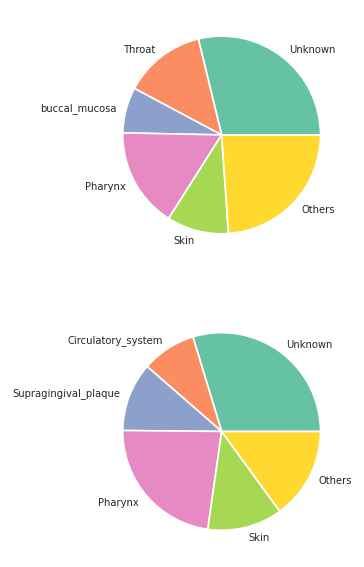

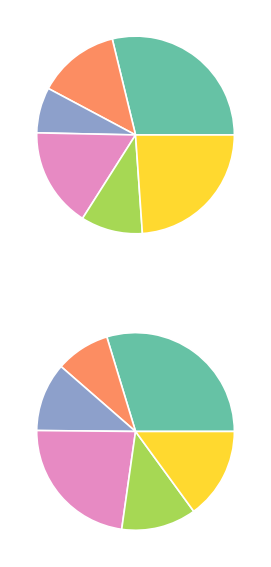

In [116]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=120, figsize=(4, 6))
st.T.plot(kind='pie', legend=F, subplots=True, ax=ax1, fontsize=6); ax1.set(xlabel="", ylabel="")
feast.T.plot(kind='pie', legend=F, subplots=True, ax=ax2, fontsize=6); ax2.set(xlabel="", ylabel="")
#plt.tight_layout()


fig, (ax1, ax2) = plt.subplots(2, 1, dpi=120, figsize=(3, 6))
st.T.plot(kind='pie', legend=F, subplots=True, ax=ax1, fontsize=6, labeldistance=None); ax1.set(xlabel="", ylabel="")
feast.T.plot(kind='pie', legend=F, subplots=True, ax=ax2, fontsize=6, labeldistance=None); ax2.set(xlabel="", ylabel="")

plt.savefig('sourcetracker_feast_mouth1.svg')

- Problems to be solved: add additional notation for repeated biomes

In [10]:
def cols_mapper(x):
    x = x.replace('Host-associated', 'Host_associated')
    if x.endswith('Fecal') or x.endswith('Digestive_system') or x.endswith('Saliva') or x.endswith('Oral') or x.endswith('Pharynx')\
        or x.endswith('Large_intestine') or x.endswith('Skin') or x.endswith('Respiratory_system'):
        return x.split('-')[-1][0:]+('({})'.format(x.split('-')[2]))
        '''elif x.endswith('Dissolved_organics_(aerobic)'):
            return ':'.join(x.split('-')[-1:])+('({})'.format(x.split('-')[-3]))'''
    else:
        return ':'.join(x.split('-')[-1:])

topn_cols = lambda df, n: df[df.columns[df.sum().isin(df.sum().nlargest(n=n))]]
keep = lambda x: x

for name in dfs.keys():
    dfs[name] = topn_cols(dfs[name][ sorted(dfs[name].columns) ], n=5)
    others = dfs[name].apply(lambda x: 1 - x.sum(), axis=1).round(2).tolist()
    dfs[name].loc[:, 'Others'] = others
    #dfs[name] = dfs[name].rename(columns=cols_mapper)
    dfs[name].index = pd.Series(dfs[name].index.to_list()).apply(lambda x: x.split()[-2] 
                                                                 if not x.split()[-2] == 'Hand'  
                                                                 else ' '.join(x.split()[-3:-1])) + pd.Series(['_1','_2'] * 5)

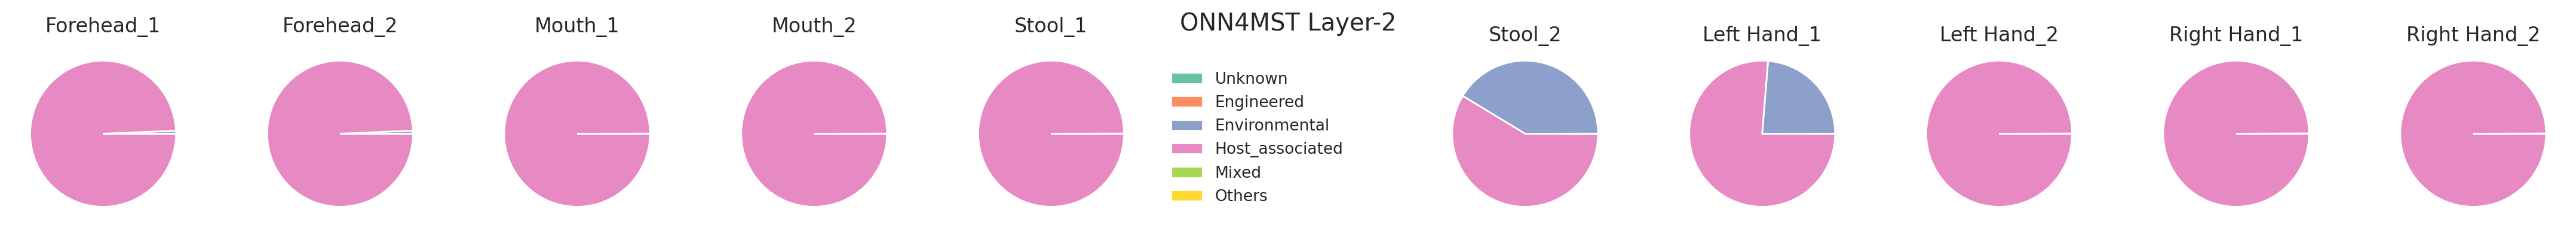

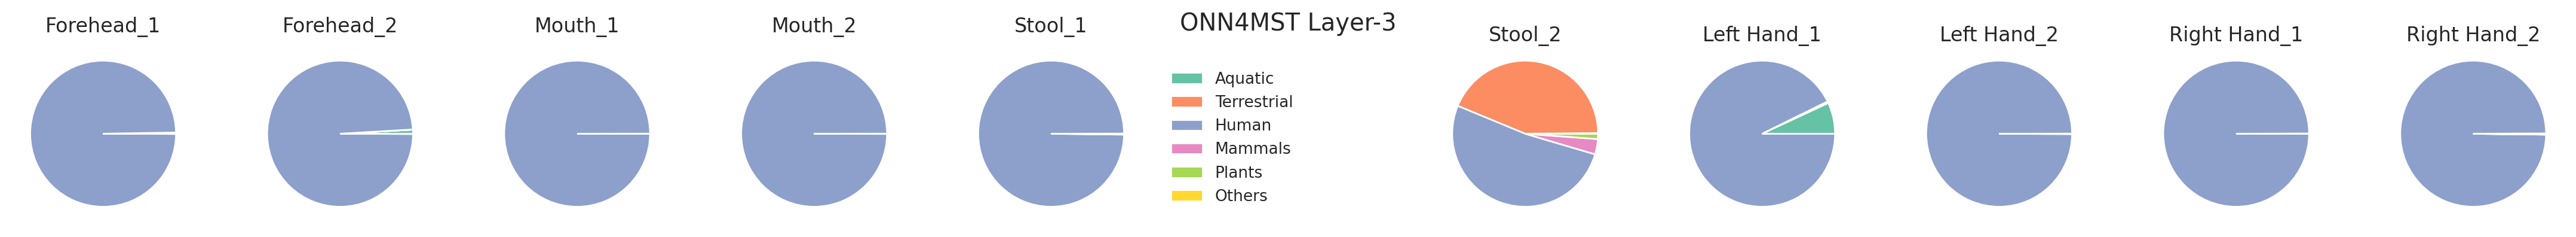

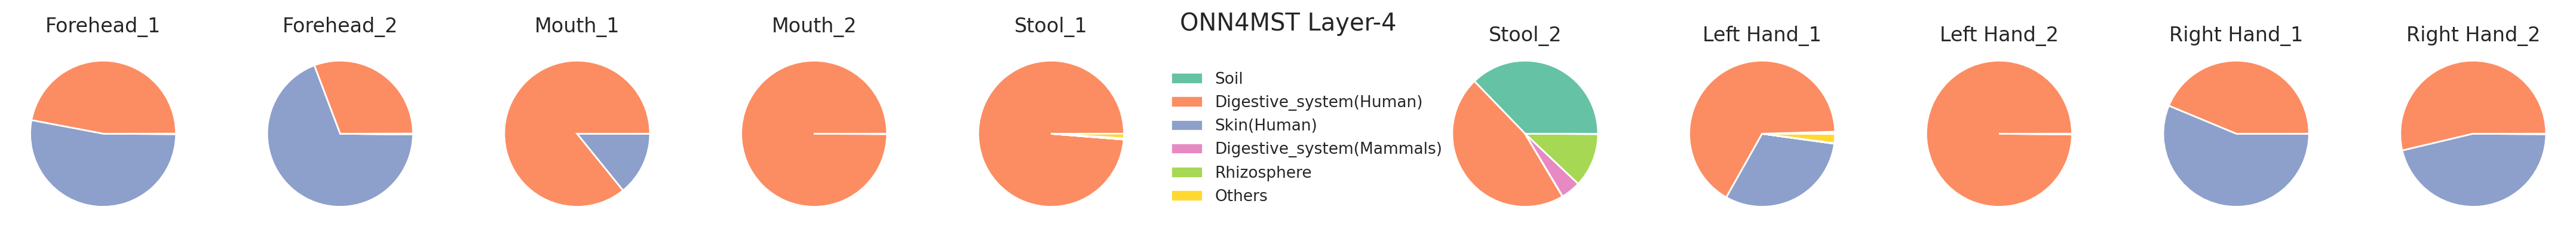

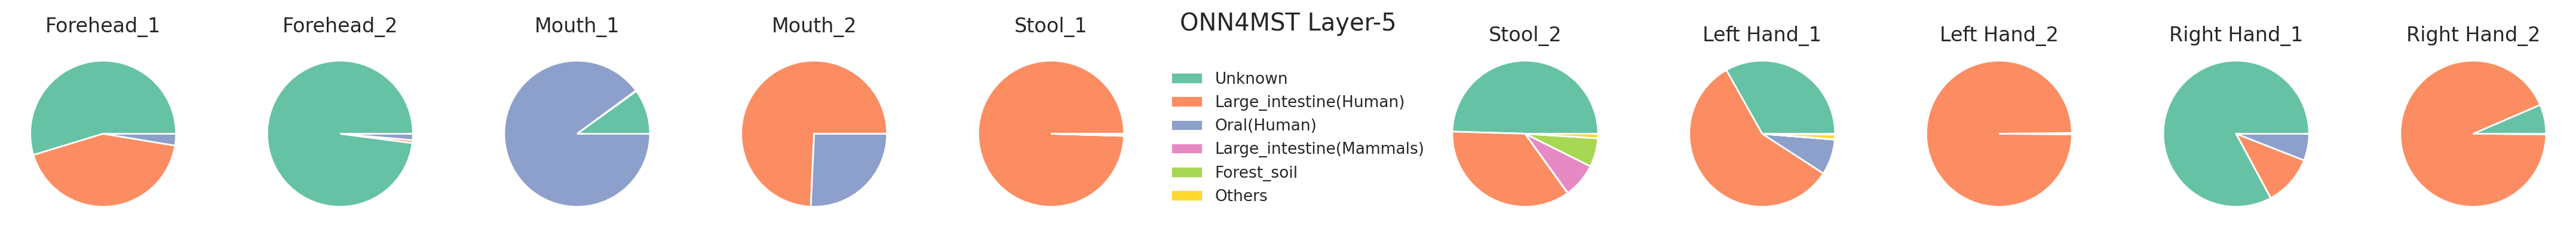

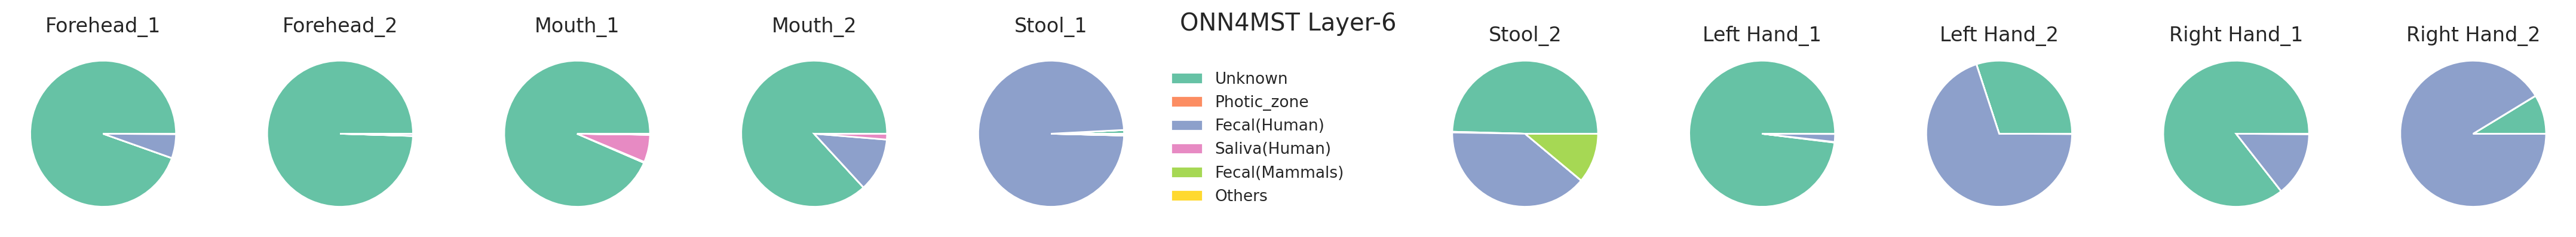

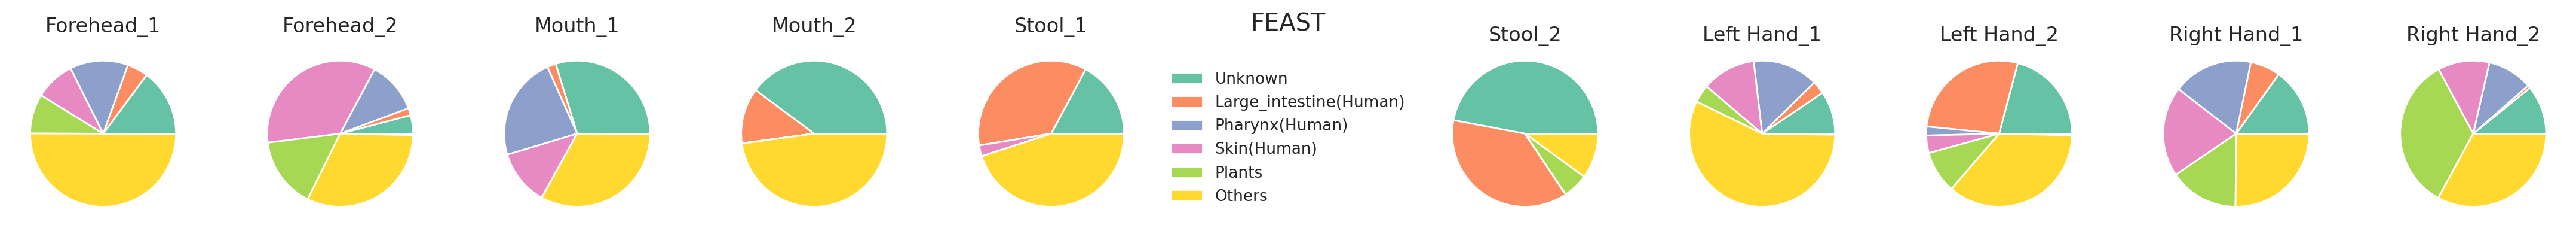

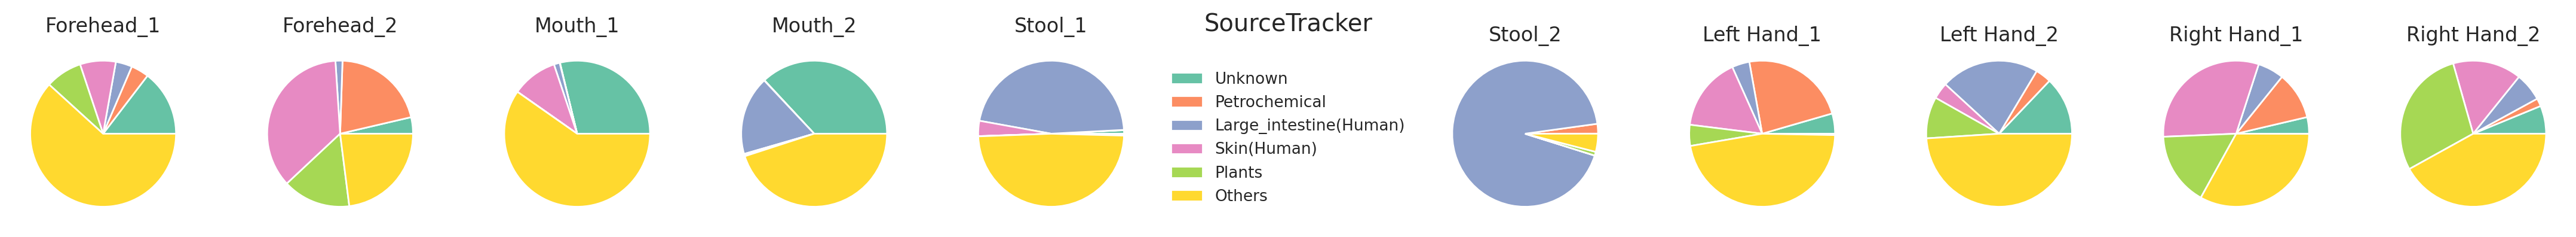

In [191]:
titles = ['ONN4MST Layer-2', 'ONN4MST Layer-3', 'ONN4MST Layer-4', 'ONN4MST Layer-5', 'ONN4MST Layer-6', 'FEAST', 'SourceTracker', ]
titles = OrderedDict( zip( ['layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'feast', 'sourcetracker'], titles) )
for name in dfs.keys():
    fig, axes = plt.subplots(1, 11, dpi=200, figsize=(22, 2))
    fig.suptitle(titles[name])
    axes = axes.flatten()
    handles, labels = ([], [])
    for i in range(len(axes)):
        if i < 5:
            df = dfs[name].iloc[i, :].T + 1e-4
            df.plot(kind='pie', legend=F, ax=axes[i], labeldistance=None)
            axes[i].set_title(df.name, fontsize=12, y=1)
            #ax.pie(df, autopct="%.1f%%", pctdistance=0.9)
        elif i == 5:
            axes[i].grid(b=None); axes[i].set_xticks([]); axes[i].set_yticks([]); axes[i].set_facecolor('white')
        else:
            df = dfs[name].iloc[i-1, :].T + 1e-4
            df.plot(kind='pie', legend=F, ax=axes[i], labeldistance=None)
            axes[i].set_title(df.name, fontsize=12, y=0.95)
        axes[i].set(xlabel="", ylabel="")
        #ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize=6.2)
        handles_labels = axes[i].get_legend_handles_labels()
        handles+= handles_labels[0] 
        labels+= handles_labels[1]
        
    fig.legend(OrderedDict.fromkeys(handles).keys(), OrderedDict.fromkeys(labels).keys(), loc='upper left', ncol=1, fontsize=9.5, bbox_to_anchor=(0.44, 0.75), 
               facecolor='white', edgecolor='white')
    plt.tight_layout()
    plt.savefig(name+'.pdf')
    plt.savefig(name+'.svg')